#Abdelrahman Radwan Mohamed Abdelaal

#48 Hours Challenge: Bias Detection And Explainability In Ai Models

#1. Preparing Dataset

In [5]:
import pandas as pd
import io

csv_data = "/content/drive/MyDrive/Nile/data (1).csv"

df = pd.read_csv(csv_data)
df.head()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0


next, we will combine relevant columns into a single text column

In [8]:
df['features_text'] = df.apply(lambda row: f"Gender: {row['Gender']} EducationLevel: {row['EducationLevel']} ExperienceYears: {row['ExperienceYears']} PreviousCompanies: {row['PreviousCompanies']} InterviewScore: {row['InterviewScore']} SkillScore: {row['SkillScore']} PersonalityScore: {row['PersonalityScore']} RecruitmentStrategy: {row['RecruitmentStrategy']}", axis=1)

display(df[['features_text', 'HiringDecision']].head())

,features_text,HiringDecision
0,Gender: 1 EducationLevel: 2 ExperienceYears: 0...,1
1,Gender: 1 EducationLevel: 4 ExperienceYears: 1...,1
2,Gender: 0 EducationLevel: 2 ExperienceYears: 3...,0
3,Gender: 1 EducationLevel: 2 ExperienceYears: 5...,0
4,Gender: 0 EducationLevel: 1 ExperienceYears: 6...,0


In [17]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
# We'll use the 'features_text' as our input and 'HiringDecision' as our target
X = df['features_text']
y = df['HiringDecision']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split into training and testing sets.")
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Data split into training and testing sets.
Training features shape: (1200,)
Testing features shape: (300,)
Training target shape: (1200,)
Testing target shape: (300,)


#2. Train a BERT Classifier

In [13]:
!pip install transformers tensorflow

In [14]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare the data for BERT
# Tokenize the 'features_text' and convert labels to tensors
X_train_encoded = tokenizer(list(X_train.values), truncation=True, padding=True, return_tensors='tf')
X_test_encoded = tokenizer(list(X_test.values), truncation=True, padding=True, return_tensors='tf')

y_train_tensor = tf.constant(y_train.values)
y_test_tensor = tf.constant(y_test.values)

# Load a pre-trained BERT model for sequence classification
# We need 2 output labels for binary classification (Hire vs. Not Hire)
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
history = bert_model.fit(
    {'input_ids': X_train_encoded['input_ids'], 'attention_mask': X_train_encoded['attention_mask']},
    y_train_tensor,
    epochs=3, # Start with a small number of epochs
    batch_size=8, # Adjust batch size based on your GPU memory
    validation_data=(
        {'input_ids': X_test_encoded['input_ids'], 'attention_mask': X_test_encoded['attention_mask']},
        y_test_tensor
    )
)

# Evaluate the model
loss, accuracy = bert_model.evaluate(
    {'input_ids': X_test_encoded['input_ids'], 'attention_mask': X_test_encoded['attention_mask']},
    y_test_tensor
)

print(f"BERT Model Accuracy: {accuracy}")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
150/150 [==============================] - 802s 5s/step - loss: 0.5187 - accuracy: 0.7583 - val_loss: 0.4467 - val_accuracy: 0.8400
Epoch 2/3
150/150 [==============================] - 815s 5s/step - loss: 0.4795 - accuracy: 0.8075 - val_loss: 0.4114 - val_accuracy: 0.8400
Epoch 3/3
10/10 [==============================] - 39s 4s/step - loss: 0.4183 - accuracy: 0.8400
BERT Model Accuracy: 0.8399999737739563


In [19]:
# The BERT model outputs logits, so we need to apply argmax to get the predicted class
y_pred_logits = bert_model.predict(
    {'input_ids': X_test_encoded['input_ids'], 'attention_mask': X_test_encoded['attention_mask']}
)[0]
y_pred = tf.argmax(y_pred_logits, axis=1).numpy()

10/10 [==============================] - 43s 4s/step


In [16]:
save_directory = "/content/drive/MyDrive/Nile"

# Save the model
bert_model.save_pretrained(save_directory)

print(f"BERT model saved to: {save_directory}")

BERT model saved to: /content/drive/MyDrive/Nile


#3. Bias Detection & Measurement

## Calculate Fairness Metrics

In [36]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming 'Gender' is the sensitive attribute (0 for one group, 1 for the other)
# We need to access the 'Gender' information for the test set
# Since we split X and y, we need to get the corresponding 'Gender' values for the test set
# We can get the indices of the test set and use them to select rows from the original df
test_indices = X_test.index
gender_test = df.loc[test_indices, 'Gender']

# Separate predictions and true labels based on gender
y_test_group_0 = y_test[gender_test == 0]
y_pred_group_0 = y_pred[gender_test == 0]

y_test_group_1 = y_test[gender_test == 1]
y_pred_group_1 = y_pred[gender_test == 1]

classes = [0, 1]
tn_0, fp_0, fn_0, tp_0 = confusion_matrix(y_test_group_0, y_pred_group_0, labels=classes).ravel()
tn_1, fp_1, fn_1, tp_1 = confusion_matrix(y_test_group_1, y_pred_group_1, labels=classes).ravel()

## 1. Demographic Parity


In [21]:
total_group_0 = len(y_test_group_0)
total_group_1 = len(y_test_group_1)

prob_pred_1_group_0 = (tp_0 + fp_0) / total_group_0 if total_group_0 > 0 else 0
prob_pred_1_group_1 = (tp_1 + fp_1) / total_group_1 if total_group_1 > 0 else 0

demographic_parity = prob_pred_1_group_0 - prob_pred_1_group_1

print(f"Demographic Parity: {demographic_parity}")


Demographic Parity: 0.051920341394025626


## 2. Equal Opportunity Difference

In [22]:
tpr_group_0 = tp_0 / (tp_0 + fn_0) if (tp_0 + fn_0) > 0 else 0
tpr_group_1 = tp_1 / (tp_1 + fn_1) if (tp_1 + fn_1) > 0 else 0

equal_opportunity_difference = tpr_group_0 - tpr_group_1

print(f"Equal Opportunity Difference: {equal_opportunity_difference}")

Equal Opportunity Difference: -0.018477043673012394


## 3. Average Odds Difference


In [23]:
fpr_group_0 = fp_0 / (fp_0 + tn_0) if (fp_0 + tn_0) > 0 else 0
fpr_group_1 = fp_1 / (fp_1 + tn_1) if (fp_1 + tn_1) > 0 else 0

average_odds_difference = 0.5 * ((fpr_group_0 - fpr_group_1) + (tpr_group_0 - tpr_group_1))

print(f"Average Odds Difference: {average_odds_difference}")

Average Odds Difference: 0.007644595046610685


## Plot disparities in prediction rates across gender groups.

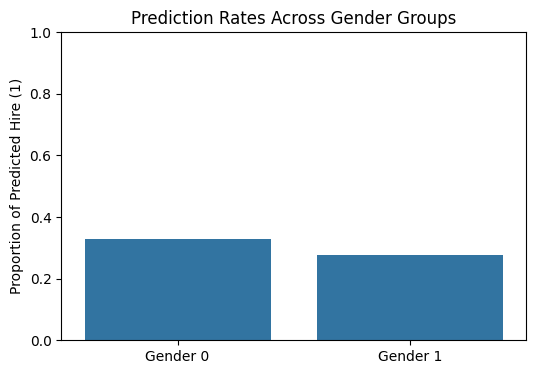

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate prediction rates for each gender group
pred_rate_group_0 = prob_pred_1_group_0
pred_rate_group_1 = prob_pred_1_group_1

group_labels = ['Gender 0', 'Gender 1']
prediction_rates = [pred_rate_group_0, pred_rate_group_1]

plt.figure(figsize=(6, 4))
sns.barplot(x=group_labels, y=prediction_rates)
plt.ylabel('Proportion of Predicted Hire (1)')
plt.title('Prediction Rates Across Gender Groups')
plt.ylim(0, 1) # Set y-axis limits to be between 0 and 1
plt.show()

#Explainability & Bias Attribution

In [25]:
!pip install shap

In [30]:
import shap
import pandas as pd
import numpy as np # Import numpy

# Select a few instances from the test set to explain (3 Hire, 2 No-Hire)
# We need the original text features (X_test) and the true labels (y_test)
# and the model's predictions (y_pred) to select instances
explained_indices = []
hire_count = 0
nohire_count = 0

# Iterate through the test set to find instances to explain
for i in range(len(X_test)):
    # Get the true label and predicted label for the current instance
    true_label = y_test.iloc[i]
    predicted_label = y_pred[i] # y_pred is a numpy array from the previous step

    # Select 3 Hire predictions
    if predicted_label == 1 and hire_count < 3:
        explained_indices.append(X_test.index[i])
        hire_count += 1
    # Select 2 No-Hire predictions
    elif predicted_label == 0 and nohire_count < 2:
        explained_indices.append(X_test.index[i])
        nohire_count += 1

    if hire_count == 3 and nohire_count == 2:
        break

X_to_explain = X_test.loc[explained_indices]
y_to_explain = y_test.loc[explained_indices]
y_pred_to_explain = y_pred[X_test.index.isin(explained_indices)] # Select corresponding predictions


print(f"Selected {len(explained_indices)} instances for explanation:")
for i, index in enumerate(explained_indices):
    print(f"Instance {i+1} (Index {index}): True Label = {y_to_explain.loc[index]}, Predicted Label = {y_pred_to_explain[i]}")
    print(f"Text Features: {X_to_explain.loc[index]}")
    print("-" * 20)

def bert_predict_proba(texts):
    if isinstance(texts, np.ndarray):
        texts = [str(t) for t in texts.flatten()] # Flatten and convert to list of strings
    elif isinstance(texts, pd.DataFrame):
        texts = texts.iloc[:, 0].tolist() # Assuming the text is in the first column of the DataFrame
    elif isinstance(texts, pd.Series):
        texts = texts.tolist()
    elif not isinstance(texts, list):
        texts = [texts] # Handle single string input

    # Tokenize the input texts
    encoded_input = tokenizer(list(texts), truncation=True, padding=True, return_tensors='tf')
    # Get model predictions (logits)
    logits = bert_model.predict(
        {'input_ids': encoded_input['input_ids'], 'attention_mask': encoded_input['attention_mask']}
    )[0]
    # Apply softmax to get probabilities
    probabilities = tf.nn.softmax(logits, axis=-1).numpy()
    return probabilities

background_data = X_train.sample(min(100, len(X_train)), random_state=42).to_numpy().reshape(-1, 1)
explainer = shap.KernelExplainer(bert_predict_proba, background_data)

print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_to_explain.to_numpy().reshape(-1, 1))

print("SHAP values calculation complete.")

Selected 5 instances for explanation:
Instance 1 (Index 1116): True Label = 0, Predicted Label = 0
Text Features: Gender: 0 EducationLevel: 2 ExperienceYears: 15 PreviousCompanies: 5 InterviewScore: 67 SkillScore: 84 PersonalityScore: 42 RecruitmentStrategy: 2
--------------------
Instance 2 (Index 1368): True Label = 0, Predicted Label = 0
Text Features: Gender: 1 EducationLevel: 2 ExperienceYears: 9 PreviousCompanies: 5 InterviewScore: 73 SkillScore: 44 PersonalityScore: 87 RecruitmentStrategy: 3
--------------------
Instance 3 (Index 259): True Label = 0, Predicted Label = 1
Text Features: Gender: 0 EducationLevel: 2 ExperienceYears: 4 PreviousCompanies: 4 InterviewScore: 17 SkillScore: 18 PersonalityScore: 24 RecruitmentStrategy: 1
--------------------
Instance 4 (Index 1382): True Label = 1, Predicted Label = 1
Text Features: Gender: 0 EducationLevel: 1 ExperienceYears: 7 PreviousCompanies: 5 InterviewScore: 74 SkillScore: 73 PersonalityScore: 20 RecruitmentStrategy: 1
-----------

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 471ms/step
SHAP values calculation complete.


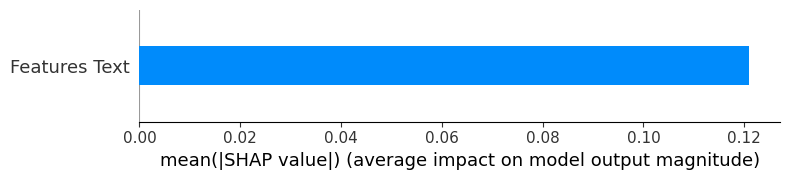

In [34]:
# Create a list of the text features for plotting
X_to_explain_list = X_to_explain.tolist()
shap.summary_plot(shap_values[1][:, :-1], features=X_to_explain.to_numpy().reshape(-1, 1), feature_names=['Features Text'], plot_type="bar")

#5. Bias Mitigation:

In [35]:
# Calculate sample weights for reweighing
# We need to access the original 'Gender' information for the training set
train_indices = X_train.index
gender_train = df.loc[train_indices, 'Gender']

train_groups = pd.DataFrame({'Gender': gender_train, 'HiringDecision': y_train})
group_proportions = train_groups.value_counts(normalize=True).sort_index()
group_weights = 1 / (group_proportions + 1e-6)

group_weights = group_weights / group_weights.sum() * len(train_groups)
sample_weights = train_groups.apply(lambda row: group_weights.get((row['Gender'], row['HiringDecision']), 0), axis=1)

print("Sample weights calculated for reweighing.")
display(sample_weights.head())

Sample weights calculated for reweighing.


,0
382,194.713735
538,194.713735
1493,194.713735
1112,409.922293
324,194.713735
